In [1]:
!pip install darts

In [2]:
!pip install seaborn

In [3]:
import torch
print(torch.__version__)  # Debería mostrar una versión como 2.2.0+cu117
print(torch.cuda.is_available())

2.4.0
False


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt


from tqdm import tqdm

import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from darts import TimeSeries
from darts.models import NBEATSModel,LightGBMModel,TFTModel
from darts.models.filtering.moving_average_filter import MovingAverageFilter

from darts.dataprocessing.transformers import MissingValuesFiller, StaticCovariatesTransformer, Scaler, InvertibleMapper
from darts.metrics import mape
from darts.dataprocessing.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Trainer

C:\Users\Ruben\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [5]:
pd.set_option('display.max_columns', None)

In [6]:
pd.set_option('display.max_rows', None)

In [7]:
#Cargamos todos los datos que nos proporciona la competición
train = pd.read_csv('train.csv',parse_dates=["date"])
train_simple = pd.read_csv('train.csv',parse_dates=["date"])
test = pd.read_csv('test.csv',parse_dates=["date"])
transactions = pd.read_csv('transactions.csv',parse_dates=["date"])
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv',parse_dates=["date"]).rename(columns={"dcoilwtico": "oil"})
events = pd.read_csv('holidays_events.csv',parse_dates=["date"])

In [8]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [9]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [10]:
#Extraemos información importante sobre el dataset como fechas de entrenamiento de inicio y final, de los test, numeros de familias, tiendas ... etc.
num_family = train.family.nunique()
num_store = train.store_nbr.nunique()
num_family_store = train.groupby(["store_nbr", "family"]).ngroups
train_start = train.date.min().date()
train_end = train.date.max().date()
num_train_date = train.date.nunique()
train_len = (train_end - train_start).days + 1
test_start = test.date.min().date()
test_end = test.date.max().date()
num_test_date = test.date.nunique()
test_len = (test_end - test_start).days + 1

In [11]:
print(f"Number of families: {num_family}")
print(f"Number of stores: {num_store}")
print(f"Number of family-store combinations: {num_family_store}")
print("-------------------")
print(f"Number of unique train dates: {num_train_date}")
print(  f"Train date range            : {train_len} days from {train_start} to {train_end}")
print(f"Test date range             : {test_len} days from {test_start} to {test_end}")

Number of families: 33
Number of stores: 54
Number of family-store combinations: 1782
-------------------
Number of unique train dates: 1684
Train date range            : 1688 days from 2013-01-01 to 2017-08-15
Test date range             : 16 days from 2017-08-16 to 2017-08-31


In [12]:
#Tenemos 33 familias, 54 tiendas y 1782 combinaciones por día
#1688 dias de entrenamientos y 16 días a predecir

In [13]:
missing_dates = pd.date_range(train_start, train_end).difference(train.date.unique())
missing_dates = missing_dates.strftime("%Y-%m-%d").tolist()

unique_dp_count = train.groupby(["store_nbr", "family"]).date.count().unique().tolist()

In [14]:
#Podemos observar que las fechas que faltan son los días de navidad y puede ser causa de que las tiendas esten cerradas por vacaciones.
print(f"Missing dates: {missing_dates}")

Missing dates: ['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25']


In [15]:
#Indexamos el dataset por tienda, familia y fechas que son las cualidades que juntas lo hacen únicos
multi_idx = pd.MultiIndex.from_product(
    [pd.date_range(train_start, train_end), train.store_nbr.unique(), train.family.unique()],
    names=["date", "store_nbr", "family"],
)
#train = train.set_index(["date", "store_nbr", "family"]).reindex(multi_idx).reset_index()
train[["sales", "onpromotion"]] = train[["sales", "onpromotion"]].fillna(0.)
train.id = train.id.interpolate(method="linear")


In [16]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [17]:
#Vamos a preprocessar la información del dataset del precio del petroleo oil
missing_oil_dates = pd.date_range(train_start, test_end).difference(oil.date)
num_missing_oil_dates = len(missing_oil_dates)
num_weekend_missing = (missing_oil_dates.weekday >= 5).sum()
total_num_wknd = (pd.date_range(train_start, test_end).weekday >= 5).sum()

In [18]:
#Faltan estas fechas porque los fin de semana la bolsa de valores esta cerrada por tanto no hay información en estos días.
print(f"Number missing dates: {num_missing_oil_dates}")
print(f"Number Weekends: {num_weekend_missing}")

Number missing dates: 486
Number Weekends: 486


In [19]:
#Mergeamos el dataset oil para que tengas los valores de todas las fechas incluidas los fin de semana.
#También completamos los valores de los fin de semanas con una interpolación hacia ambos lados.
oil = oil.merge(
    pd.DataFrame({"date": pd.date_range(train_start, test_end)}),
    on="date",
    how="outer",
).sort_values("date", ignore_index=True)
oil.oil = oil.oil.interpolate(method="linear", limit_direction="both")

In [20]:
oil.head()

,date,oil
0,2013-01-01,93.140000
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-05,93.146667


In [21]:
num_zero_sales = (train.groupby(["date", "store_nbr"]).sales.sum().eq(0)).sum()
supposed_num_records = num_store * train_len
actual_records = len(transactions.index)
missing_records = supposed_num_records - actual_records - num_zero_sales

In [22]:
print(f"Num Zero sales: {num_zero_sales}")
print(f"Supposed number of records: {supposed_num_records}")
print(f"Actual number of records: {actual_records}")
print(f"Number of missing record: {missing_records}")

Num Zero sales: 7330
Supposed number of records: 91152
Actual number of records: 83488
Number of missing record: 334


In [23]:
#Como vemos falta información en el dataset de transactions porque no recoje información de los días que no ha habido ventas.
#Vamos a completar el dataset de train con la información correspondiente de los días faltantes
store_sales = train.groupby(["date", "store_nbr"]).sales.sum().reset_index()
transactions = transactions.merge(
    store_sales,
    on=["date", "store_nbr"],
    how="outer",
).sort_values(["date", "store_nbr"], ignore_index=True)
transactions.loc[transactions.sales.eq(0), "transactions"] = 0.
transactions = transactions.drop(columns=["sales"])
transactions.transactions = transactions.groupby("store_nbr", group_keys=False).transactions.apply(
    lambda x: x.interpolate(method="linear", limit_direction="both")
)

In [24]:
#Dividimos los eventos en Nacionales, Regionales y Locales
national_events_name = sorted(events[events.locale.eq("National")].description.unique().tolist())
regional_events_name = sorted(events[events.locale.eq("Regional")].description.unique().tolist())
local_events_name = sorted(events[events.locale.eq("Local")].description.unique().tolist())

In [25]:
print(national_events_name)
print("#####################################################")
print(regional_events_name)
print("#####################################################")
print(local_events_name)

['Batalla de Pichincha', 'Black Friday', 'Carnaval', 'Cyber Monday', 'Dia de Difuntos', 'Dia de la Madre', 'Dia de la Madre-1', 'Dia del Trabajo', 'Inauguracion Mundial de futbol Brasil', 'Independencia de Cuenca', 'Independencia de Guayaquil', 'Mundial de futbol Brasil: Cuartos de Final', 'Mundial de futbol Brasil: Ecuador-Francia', 'Mundial de futbol Brasil: Ecuador-Honduras', 'Mundial de futbol Brasil: Ecuador-Suiza', 'Mundial de futbol Brasil: Final', 'Mundial de futbol Brasil: Octavos de Final', 'Mundial de futbol Brasil: Semifinales', 'Mundial de futbol Brasil: Tercer y cuarto lugar', 'Navidad', 'Navidad+1', 'Navidad-1', 'Navidad-2', 'Navidad-3', 'Navidad-4', 'Primer Grito de Independencia', 'Primer dia del ano', 'Primer dia del ano-1', 'Puente Dia de Difuntos', 'Puente Navidad', 'Puente Primer dia del ano', 'Recupero Puente Dia de Difuntos', 'Recupero Puente Navidad', 'Recupero Puente Primer dia del ano', 'Recupero puente Navidad', 'Recupero puente primer dia del ano', 'Terremot

In [26]:
#Como vemos hay muchas vacaciones y eventos que tienen nombre similares, por ello simplicaremos los nombres para que el dataset sea mas simple

events.loc[events['description'].str.contains('Navidad', case=False), 'description'] = 'Navidad'
events.loc[events['description'].str.contains('futbol', case=False), 'description'] = 'futbol'
events.loc[events['description'].str.contains('Terremoto Manabi', case=False), 'description'] = 'Terremoto Manabi'

In [27]:
#Ahora vamos a preprocesar las vacaciones que han sido transferidas y añadirles un prefijo

# remove transferred holidays
events = events[events.transferred.eq(False)]

#########################################
### Saturdays designated as work days ###
#########################################
work_days = events[events.type.eq("Work Day")]
print(work_days)
work_days = work_days[["date", "type"]].rename(
    columns={"type": "work_day"}
).reset_index(drop=True)

work_days.work_day = work_days.work_day.notna().astype(int)

# remove work days after extracting above
events = events[events.type!="Work Day"].reset_index(drop=True)

###################################
### local holidays (city level) ###
###################################
local_holidays = events[events.locale.eq("Local")]
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "city"}
).reset_index(drop=True)
local_holidays = local_holidays[~local_holidays.duplicated()]
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc")

#######################################
### regional holidays (state level) ###
#######################################
regional_holidays = events[events.locale.eq("Regional")]
regional_holidays = regional_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "state", "description": "provincializacion"}
).reset_index(drop=True)
regional_holidays.provincializacion = regional_holidays.provincializacion.eq("provincializacion").astype(int)

#########################
### national holidays ###
#########################
national_holidays = events[events.locale.eq("National")]
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)
national_holidays = national_holidays[~national_holidays.duplicated()]
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")
# different national holidays may fall on the same day
national_holidays = national_holidays.groupby("date").sum().reset_index()
# shorten name for visualization purposes later
national_holidays = national_holidays.rename(columns={"nat_primer grito independencia": "nat_primer grito"})

events.head()

          date      type    locale locale_name  \
42  2013-01-05  Work Day  National     Ecuador   
43  2013-01-12  Work Day  National     Ecuador   
149 2014-12-20  Work Day  National     Ecuador   
161 2015-01-10  Work Day  National     Ecuador   
283 2016-11-12  Work Day  National     Ecuador   

                            description  transferred  
42                              Navidad        False  
43   Recupero puente primer dia del ano        False  
149                             Navidad        False  
161  Recupero Puente Primer dia del ano        False  
283     Recupero Puente Dia de Difuntos        False  


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [28]:
events["type"].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Event'],
      dtype=object)

# Data Exploration

In [29]:
data_explorer = pd.concat(
    [train ], axis=0, ignore_index=True,
).merge(
    oil, on="date", how="left",
).merge(
    stores, on="store_nbr", how="left",
).merge(
    work_days, on="date", how="left",
).merge(
    events, on="date", how="left",
).sort_values(["date", "store_nbr", "family"], ignore_index=True)

# fill columns with 0s to indicate absence of holidays/events


# include date-related future covariates
data_explorer["day"] = data_explorer.date.dt.day
data_explorer["month"] = data_explorer.date.dt.month
data_explorer["year"] = data_explorer.date.dt.year
data_explorer["day_of_week"] = data_explorer.date.dt.dayofweek
data_explorer["day_of_year"] = data_explorer.date.dt.dayofyear
data_explorer["week_of_year"] = data_explorer.date.dt.isocalendar().week.astype(int)
data_explorer["date_index"] = data_explorer.date.factorize()[0] # sort by date above before computing this

In [30]:
work_days.head()

,date,work_day
0,2013-01-05,1
1,2013-01-12,1
2,2014-12-20,1
3,2015-01-10,1
4,2016-11-12,1


In [31]:
data_explorer.head()

,id,date,store_nbr,family,sales,onpromotion,oil,city,state,type_x,cluster,work_day,type_y,locale,locale_name,description,transferred,day,month,year,day_of_week,day_of_year,week_of_year,date_index
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0


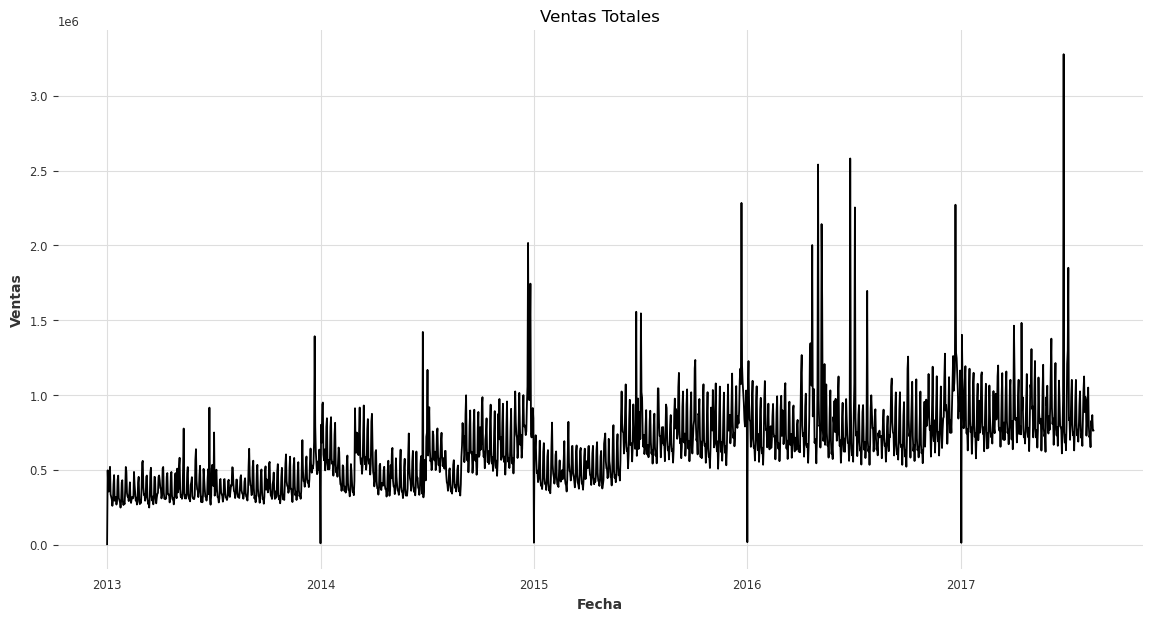

In [32]:
#Vamos a ver las ventas totales por día, y vemos que tiene un caracter creciente.
#Podemos observar 2 días al año donde no se producen ventas o casi no se producen que coinciden con el dia de navidad.
plt.figure(figsize=(14, 7))
plt.plot(data_explorer.groupby('date').sum()['sales'])
plt.title('Ventas Totales')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.show()

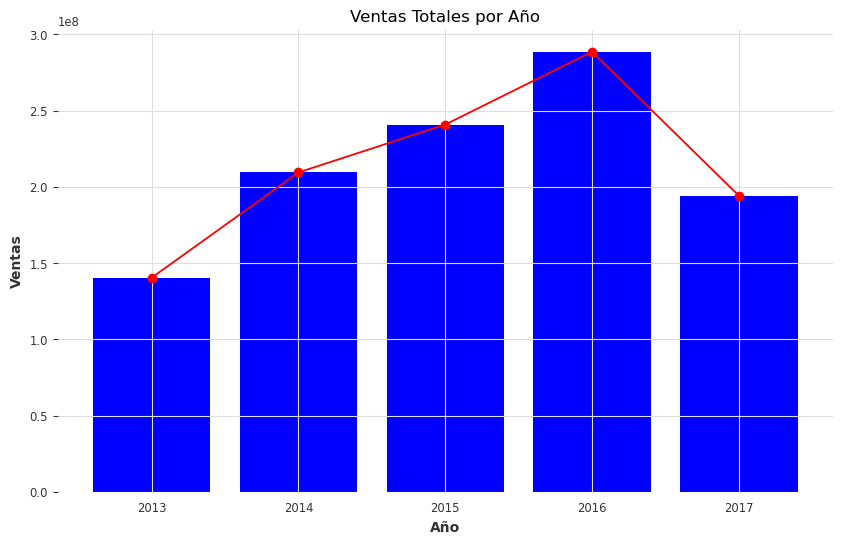

In [33]:
#Anualmente también es creciente pero como el dataset de train termina en agosto, por eso en 2017 hay menos ventas
sales_by_year = train.groupby(pd.to_datetime(train['date']).dt.year)['sales'].sum().reset_index()
sales_by_year.rename(columns={'date': 'year'}, inplace=True)
plt.figure(figsize=(10,6))
plt.plot(sales_by_year['year'],sales_by_year['sales'], marker='o', linestyle='-', color='r')
plt.bar(sales_by_year['year'], sales_by_year['sales'], color='b')
plt.title('Ventas Totales por Año')
plt.xlabel('Año')
plt.ylabel('Ventas')
plt.grid(True)
plt.show() 

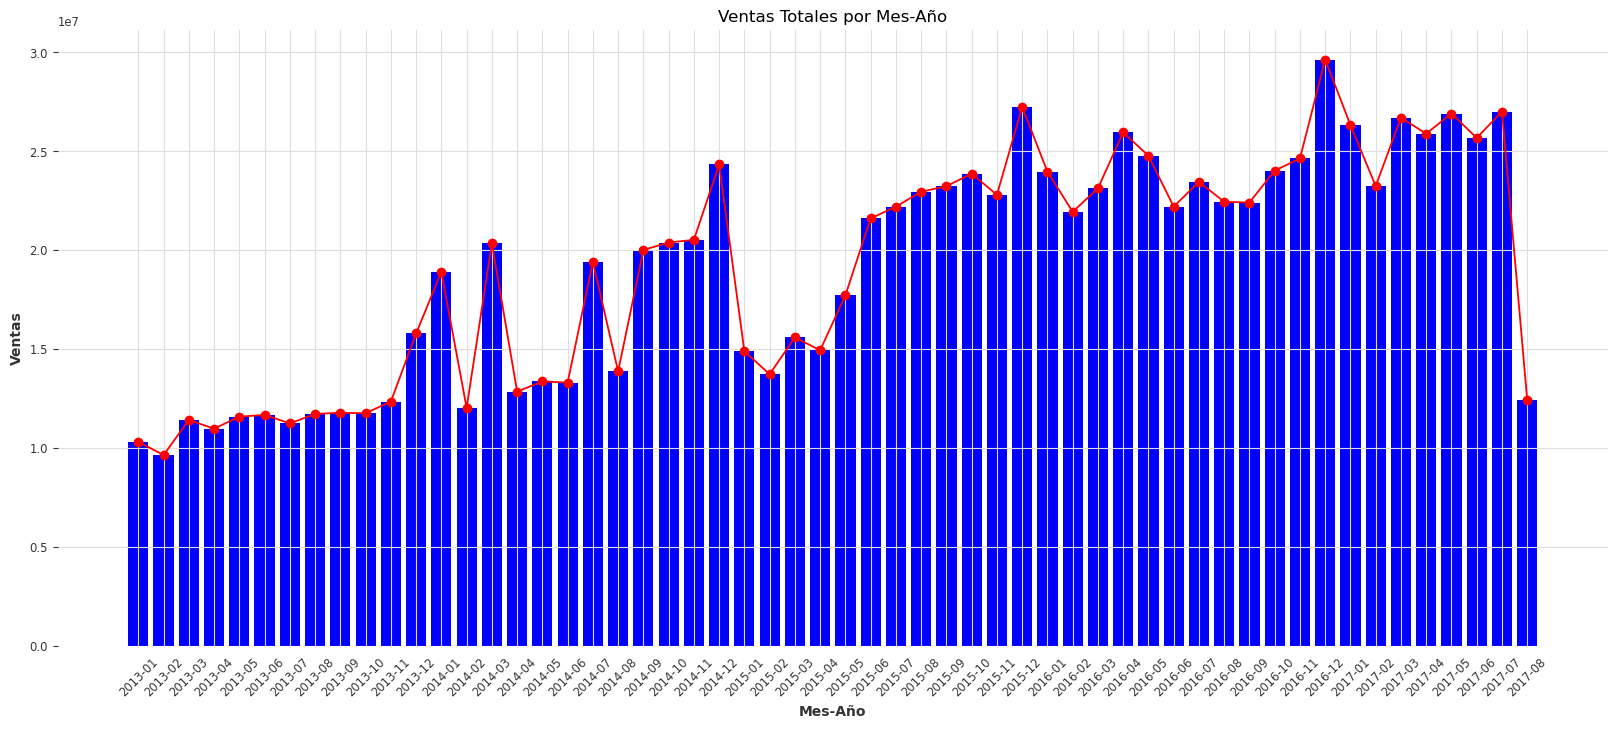

In [34]:
#Vemos que los el mes de Diciembre suele ser el mes en el que más ventas hay
sales_by_year_month = train.groupby(pd.to_datetime(train['date']).dt.to_period('M').astype(str))['sales'].sum().reset_index()
sales_by_year_month.rename(columns={'date': 'month-year'}, inplace=True)
plt.figure(figsize=(20,8))
plt.plot(sales_by_year_month['month-year'],sales_by_year_month['sales'], marker='o', linestyle='-', color='r')
plt.bar(sales_by_year_month['month-year'], sales_by_year_month['sales'], color='b')
plt.xticks(rotation=45)
plt.title('Ventas Totales por Mes-Año')
plt.xlabel('Mes-Año')
plt.ylabel('Ventas')
plt.grid(True)
plt.show() 

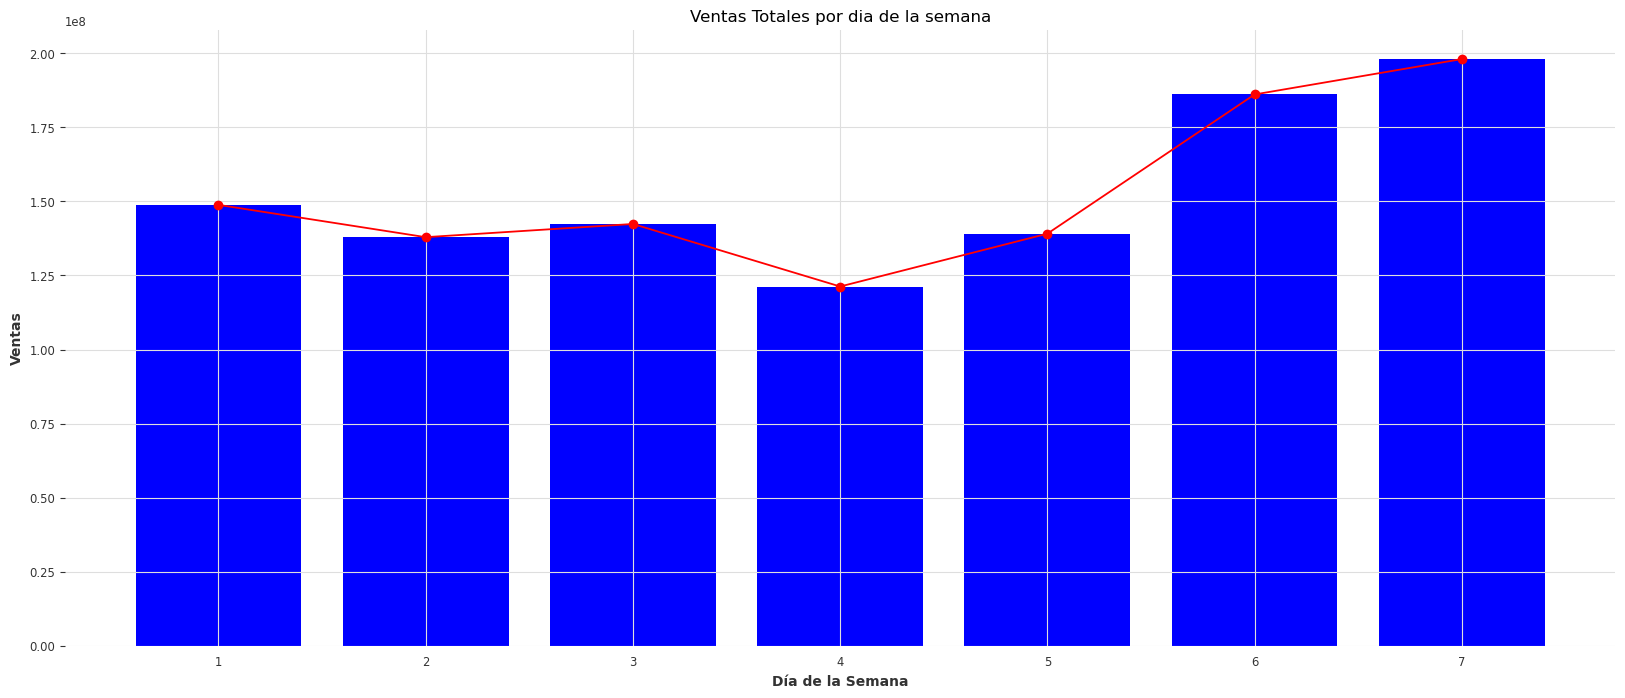

In [35]:
#Vemos que por lo general el día de la semana que vemos se vende es el jueves y los que más sabado y domingo
sales_by_day_week = train.groupby(pd.to_datetime(train['date']).dt.dayofweek + 1)['sales'].sum().reset_index()
sales_by_day_week.rename(columns={'date': 'day_of_week'}, inplace=True)

plt.figure(figsize=(20,8))
plt.plot(sales_by_day_week['day_of_week'],sales_by_day_week['sales'], marker='o', linestyle='-', color='r')
plt.bar(sales_by_day_week['day_of_week'], sales_by_day_week['sales'], color='b')
plt.title('Ventas Totales por dia de la semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Ventas')
plt.grid(True)
plt.show() 

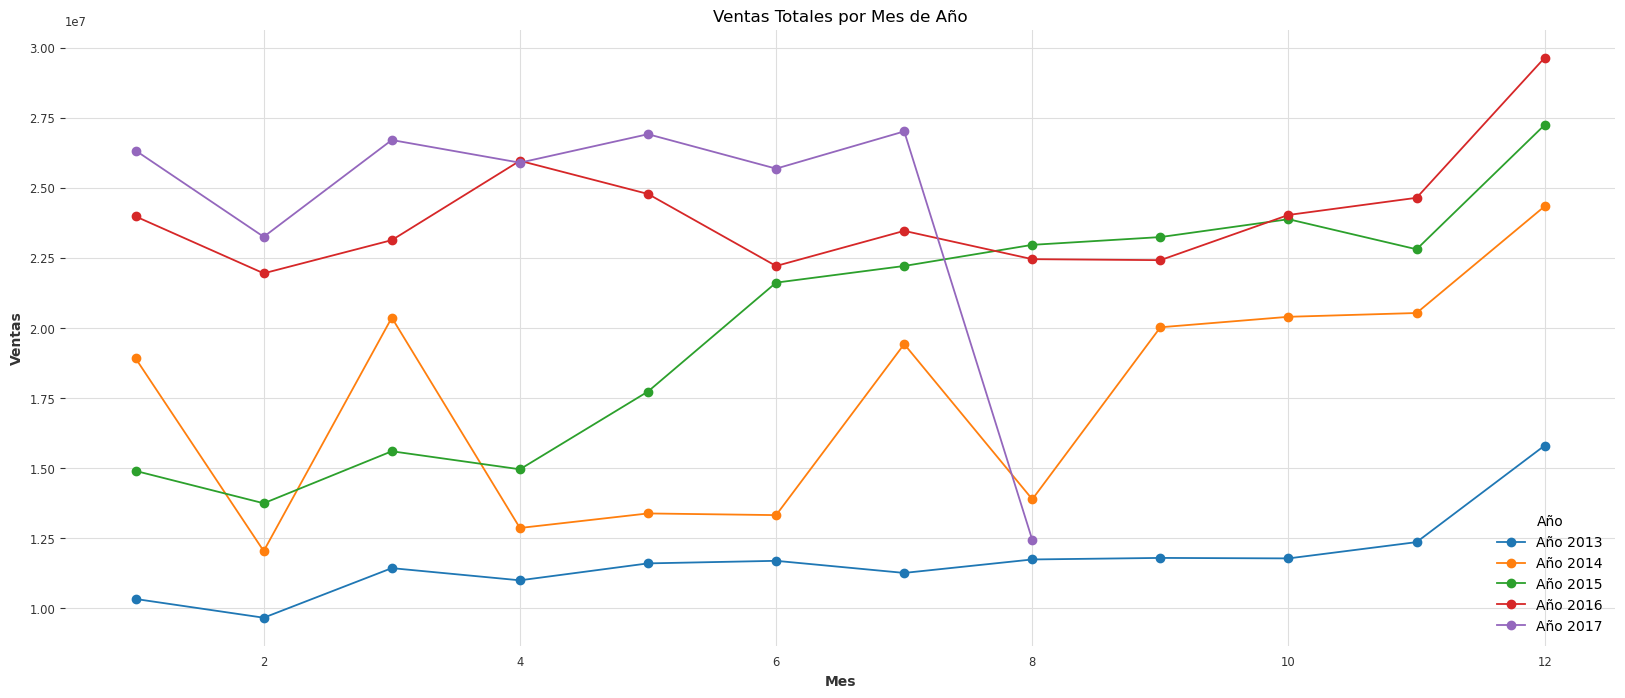

In [36]:
sales_by_year_month = train.assign(
    year=pd.to_datetime(train['date']).dt.year,
    month=pd.to_datetime(train['date']).dt.month
)

sales_by_year_month = sales_by_year_month.groupby(['year', 'month'])['sales'].sum().reset_index()

# Crear el gráfico de líneas
plt.figure(figsize=(20, 8))

# Colores para cada año
colors = plt.cm.tab10(range(len(sales_by_year_month['year'].unique())))

# Trazar cada año por separado
for i, year in enumerate(sales_by_year_month['year'].unique()):
    data_for_year = sales_by_year_month[sales_by_year_month['year'] == year]
    plt.plot(data_for_year['month'], data_for_year['sales'], marker='o', linestyle='-', color=colors[i], label=f'Año {year}')

plt.title('Ventas Totales por Mes de Año')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.legend(title='Año')
plt.grid(True)
plt.show()
#Esta gráfica que las ventas tienen tendencia a aumentar a lo largo que pasa el año
#También podemos ver que el último año (2017) iba teniendo un resultados mayores a los años anteriores, pero por la falta de información del resto
#del año decae, pero por la tendencia podemos especular que 2017 acabará con mayores ventas que los años anteriores

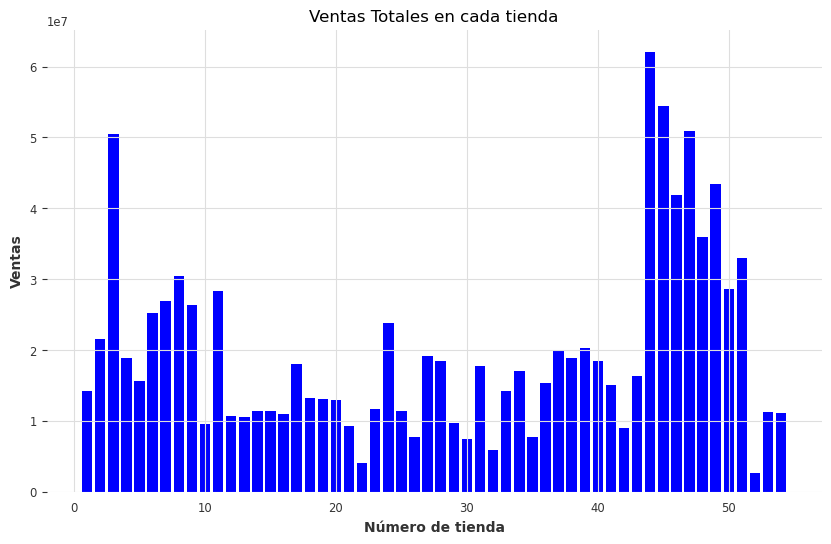

In [37]:
sales_by_store = train.groupby('store_nbr')['sales'].sum().reset_index()
plt.figure(figsize=(10,6))
plt.bar(sales_by_store['store_nbr'], sales_by_store['sales'], color='b')
plt.title('Ventas Totales en cada tienda')
plt.xlabel('Número de tienda')
plt.ylabel('Ventas')

plt.grid(True)
plt.show()

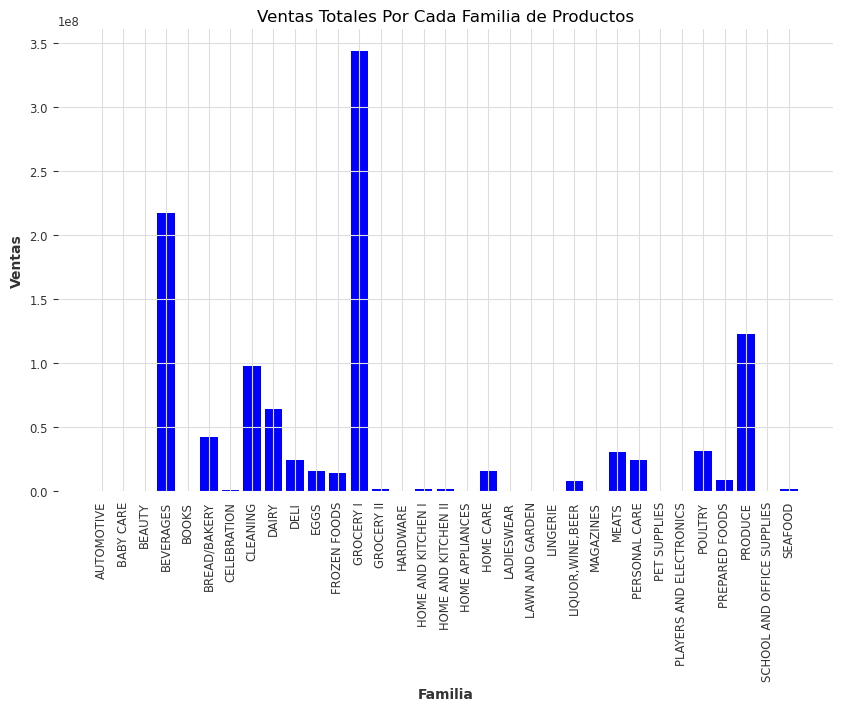

In [38]:
sales_by_family = train.groupby('family')['sales'].sum().reset_index()
plt.figure(figsize=(10,6))
plt.bar(sales_by_family['family'], sales_by_family['sales'], color='b')
plt.xticks(rotation=90)
plt.title('Ventas Totales Por Cada Familia de Productos')
plt.xlabel('Familia')
plt.ylabel('Ventas')

plt.grid(True)
plt.show()
#Observamos que la mayoría de las ventas son producidad por unas cuantas familias de productos

In [39]:
data_explorer.head()

,id,date,store_nbr,family,sales,onpromotion,oil,city,state,type_x,cluster,work_day,type_y,locale,locale_name,description,transferred,day,month,year,day_of_week,day_of_year,week_of_year,date_index
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0


In [40]:
#Agrupamos las ventas por las fechas y el precio del petroleo para ver la correlación que tiene
mean_sales_per_day = data_explorer.groupby('date')['sales'].mean().reset_index()['sales']
oil_per_day = data_explorer.groupby('date')['oil'].first().reset_index()['oil']

<Axes: xlabel='oil', ylabel='sales'>

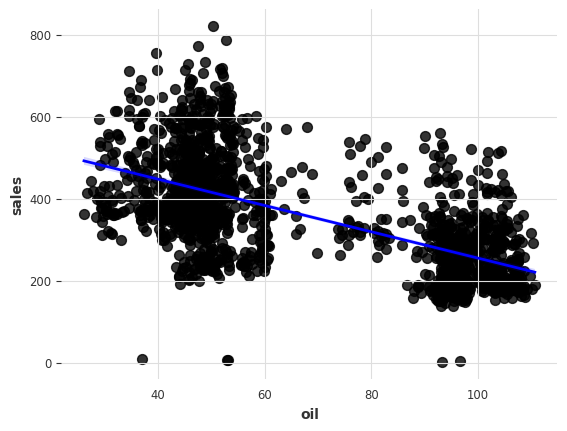

In [41]:
#Vemos que tiene una correlación negativa a mayor el precio de petroleo menos ventas se producen
sns.regplot(x=oil_per_day, y=mean_sales_per_day, scatter_kws={'s':50}, line_kws={'color':'blue'})

<Axes: xlabel='onpromotion', ylabel='sales'>

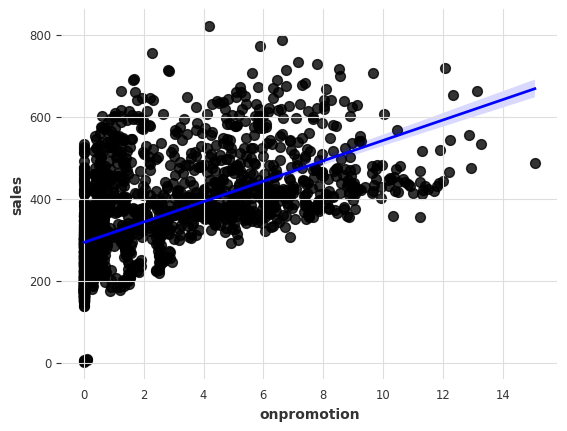

In [42]:
#Ahora vemos que tiene correlacion positiva con el numero de productos que este en promocion
onpromotion_per_day = data_explorer.groupby('date')['onpromotion'].mean().reset_index()['onpromotion']
sns.regplot(x=onpromotion_per_day, y=mean_sales_per_day, scatter_kws={'s':50}, line_kws={'color':'blue'})

In [43]:
data_explorer['state'].unique()

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

Text(0, 0.5, 'Number of Unique Stores')

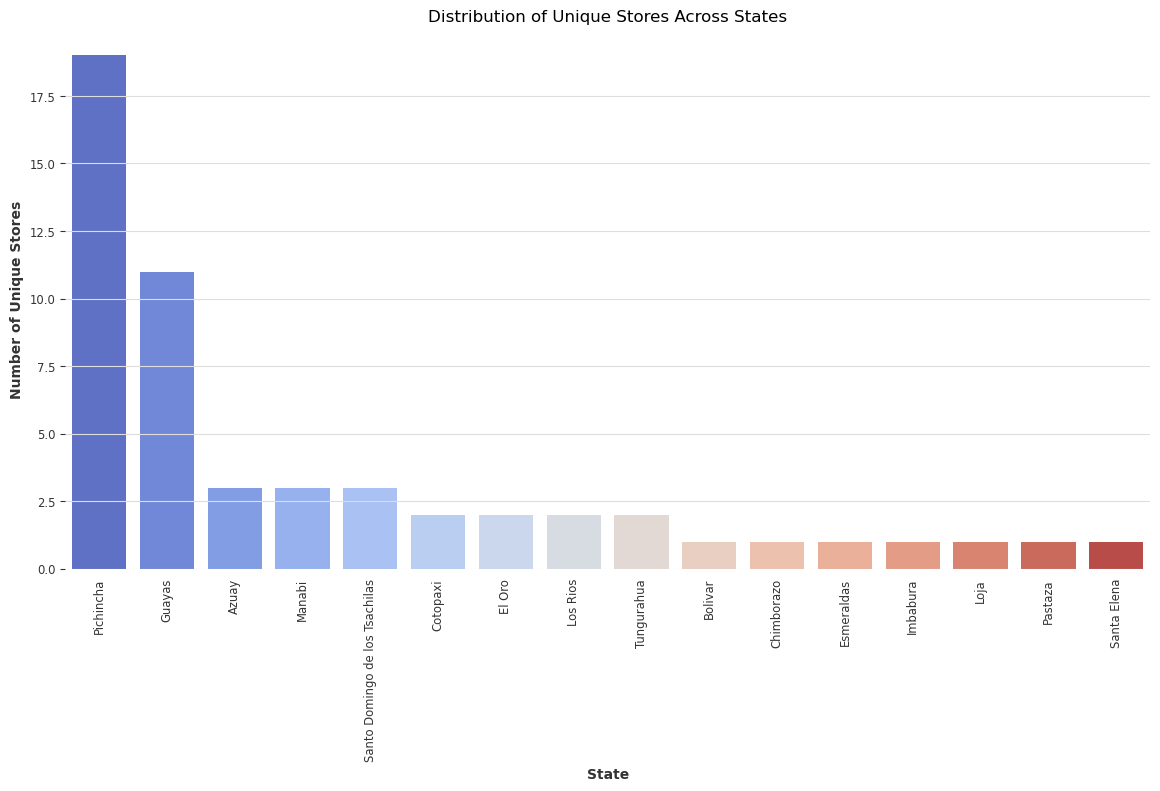

In [44]:
#Ahora vemos la cantidad de tiendas que pertenecen a cada estado, y vemos que la mayor parte de las tiendas esta dividida en 2 estados
unique_stores = data_explorer[['state', 'store_nbr']].drop_duplicates()
store_counts = unique_stores.groupby('state')['store_nbr'].count().reset_index()
store_counts = store_counts.rename(columns={'store_nbr': 'number_of_stores'})
store_counts = store_counts.sort_values(by='number_of_stores', ascending=False)
# Configurar el tamaño de la figura
plt.figure(figsize=(14, 7))

# Crear el gráfico de barras
sns.barplot(x='state', y='number_of_stores', data=store_counts, palette='coolwarm')

plt.xticks(rotation=90)
# Añadir títulos y etiquetas
plt.title('Distribution of Unique Stores Across States')
plt.xlabel('State')
plt.ylabel('Number of Unique Stores')


In [45]:
data_explorer.head()

,id,date,store_nbr,family,sales,onpromotion,oil,city,state,type_x,cluster,work_day,type_y,locale,locale_name,description,transferred,day,month,year,day_of_week,day_of_year,week_of_year,date_index
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0


In [46]:
data_explorer["description"].unique()

array(['Primer dia del ano', nan, 'Carnaval', 'Fundacion de Manta',
       'Provincializacion de Cotopaxi', 'Fundacion de Cuenca',
       'Cantonizacion de Libertad', 'Cantonizacion de Riobamba',
       'Viernes Santo', 'Dia del Trabajo', 'Dia de la Madre-1',
       'Cantonizacion del Puyo', 'Dia de la Madre',
       'Batalla de Pichincha', 'Cantonizacion de Guaranda',
       'Provincializacion de Imbabura', 'Fundacion de Machala',
       'Cantonizacion de Latacunga', 'Cantonizacion de El Carmen',
       'Fundacion de Santo Domingo', 'Cantonizacion de Cayambe',
       'Fundacion de Guayaquil-1', 'Fundacion de Guayaquil',
       'Fundacion de Esmeraldas', 'Primer Grito de Independencia',
       'Fundacion de Riobamba', 'Fundacion de Ambato',
       'Fundacion de Ibarra', 'Cantonizacion de Quevedo',
       'Traslado Independencia de Guayaquil', 'Dia de Difuntos',
       'Independencia de Cuenca', 'Provincializacion de Santo Domingo',
       'Provincializacion Santa Elena', 'Independencia

In [47]:
#Ahora vamos a calcular el impacto que tienen sobre sales las distintas festividades


# Agrupar por fecha y calcular la media de ventas diarias
daily_sales = data_explorer.groupby('date')['sales'].mean().reset_index()
# Unir la columna 'description' al DataFrame, asegurando que cada día tenga la festividad correcta
daily_sales = pd.merge(daily_sales, data_explorer[['date', 'description']].drop_duplicates(), on='date', how='left')
daily_sales = daily_sales.rename(columns={'sales': 'average_sales'})
daily_sales.head()

,date,average_sales,description
0,2013-01-01,1.409438,Primer dia del ano
1,2013-01-02,278.390807,NaN
2,2013-01-03,202.840197,NaN
3,2013-01-04,198.911154,NaN
4,2013-01-05,267.873244,NaN


In [48]:
# Calcular la media de ventas en días normales (sin festividad)
average_sales_normal_days = daily_sales[daily_sales['description'].isna()]['average_sales'].mean()
# Filtrar los días con festividad (donde description no es NaN)
festive_days = daily_sales[~daily_sales['description'].isna()]

# Calcular la media de ventas por festividad y el impacto respecto a días normales
mean_sales_by_festivity = festive_days.groupby('description')['average_sales'].mean().reset_index()

# Calcular el impacto en ventas comparado con los días normales
mean_sales_by_festivity['impact_on_sales'] = mean_sales_by_festivity['average_sales'] - average_sales_normal_days
# Ordenar por impacto en ventas (positivo o negativo)
mean_sales_by_festivity = mean_sales_by_festivity.sort_values(by='impact_on_sales', ascending=False)

In [49]:
mean_sales_by_festivity.tail()

,description,average_sales,impact_on_sales
0,Batalla de Pichincha,309.219029,-42.639103
51,Viernes Santo,292.693438,-59.164695
10,Cantonizacion del Puyo,292.534443,-59.323689
6,Cantonizacion de Libertad,286.318917,-65.539215
37,Primer dia del ano,5.656663,-346.201469


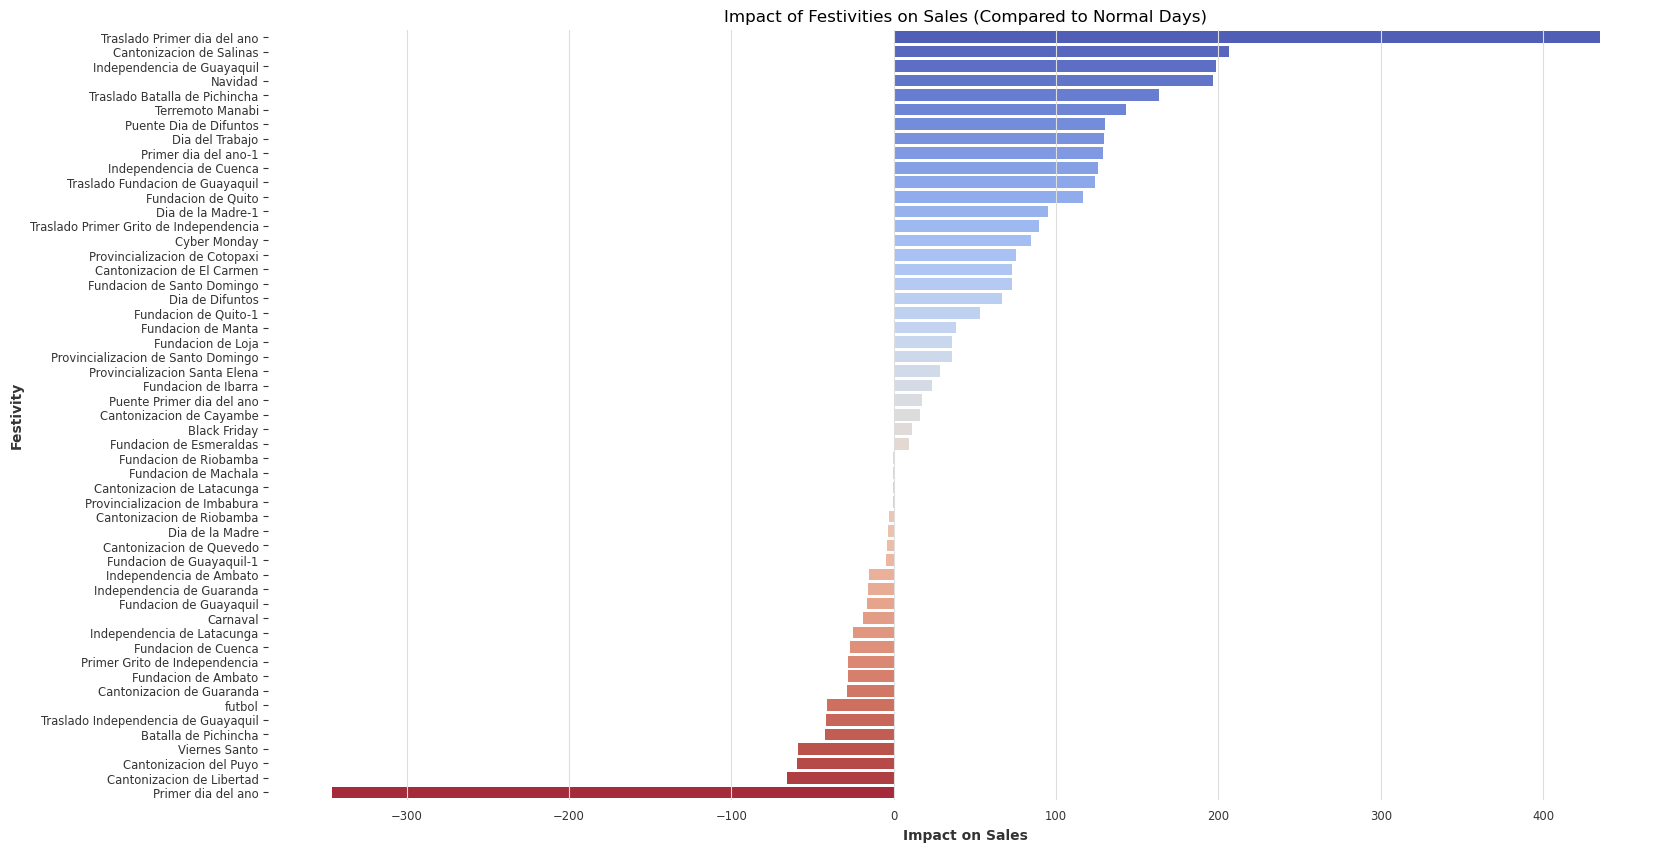

In [50]:
plt.figure(figsize=(18, 10))

# Crear el gráfico de barras
sns.barplot(x='impact_on_sales', y='description', data=mean_sales_by_festivity, palette='coolwarm')

# Añadir títulos y etiquetas
plt.title('Impact of Festivities on Sales (Compared to Normal Days)')
plt.xlabel('Impact on Sales')
plt.ylabel('Festivity')

# Mostrar la gráfica
plt.show()

In [51]:
# Calcular el valor absoluto del impacto en ventas
mean_sales_by_festivity['abs_impact_on_sales'] = mean_sales_by_festivity['impact_on_sales'].abs()
# Ordenar por el impacto absoluto en ventas
mean_sales_by_festivity_sorted = mean_sales_by_festivity.sort_values(by='abs_impact_on_sales', ascending=False)
# Extraer los nombres de las 10 festividades con mayor impacto en valor absoluto
top_15_festivities = mean_sales_by_festivity_sorted['description'].head(15).tolist()


In [52]:
top_15_festivities

['Traslado Primer dia del ano',
 'Primer dia del ano',
 'Cantonizacion de Salinas',
 'Independencia de Guayaquil',
 'Navidad',
 'Traslado Batalla de Pichincha',
 'Terremoto Manabi',
 'Puente Dia de Difuntos',
 'Dia del Trabajo',
 'Primer dia del ano-1',
 'Independencia de Cuenca',
 'Traslado Fundacion de Guayaquil',
 'Fundacion de Quito',
 'Dia de la Madre-1',
 'Traslado Primer Grito de Independencia']

In [53]:
national_holidays.columns

Index(['date', 'nat_Batalla de Pichincha', 'nat_Black Friday', 'nat_Carnaval',
       'nat_Cyber Monday', 'nat_Dia de Difuntos', 'nat_Dia de la Madre',
       'nat_Dia de la Madre-1', 'nat_Dia del Trabajo',
       'nat_Independencia de Cuenca', 'nat_Independencia de Guayaquil',
       'nat_Navidad', 'nat_Primer Grito de Independencia',
       'nat_Primer dia del ano', 'nat_Primer dia del ano-1',
       'nat_Puente Dia de Difuntos', 'nat_Puente Primer dia del ano',
       'nat_Terremoto Manabi', 'nat_Traslado Batalla de Pichincha',
       'nat_Traslado Independencia de Guayaquil',
       'nat_Traslado Primer Grito de Independencia',
       'nat_Traslado Primer dia del ano', 'nat_Viernes Santo', 'nat_futbol'],
      dtype='object')

## Trainning

In [54]:
#Vamos a crear las TimeSeries necesarias para entrenar nuesto modelo de Darts
#Necesitamos la Target Series, future covariates y past covariates
# De paso también añadiremos medias moviles para incluir mas información 
train = pd.merge(train, stores, on ='store_nbr')
train = train.sort_values(["store_nbr","family","date"])
test = test.sort_values(["store_nbr","family","date"])
train = train.astype({"store_nbr":'str', "family":'str', "city":'str',
                          "state":'str', "type":'str', "cluster":'str'})
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
33,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13
66,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13
99,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13
132,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13


In [55]:
#Cogemos el dataframe de test para posteriormente utilizarlo para la submission y ordenamos por tienda y familia de productos
test_submit = test.drop(['onpromotion'],axis=1)
test_submit = test.sort_values(by=["store_nbr",'family'])
test_submit.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1782,3002670,2017-08-17,1,AUTOMOTIVE,0
3564,3004452,2017-08-18,1,AUTOMOTIVE,0
5346,3006234,2017-08-19,1,AUTOMOTIVE,0
7128,3008016,2017-08-20,1,AUTOMOTIVE,0


In [56]:
#Creamos el timserie target que contiene la información de sales
families = train["family"].unique()
sales_fam_ts = {}
for fam in families:
    family_df = train.loc[train['family'] == fam]
    family_ts = TimeSeries.from_group_dataframe(family_df,
                                                time_col='date',
                                                group_cols=['store_nbr','family'],
                                                static_cols=['city','state','type','cluster'],
                                                value_cols='sales',
                                                fill_missing_dates=True,
                                                freq='D'
                                               )
    for ts in family_ts:
        ts = ts.astype(np.float32)
    family_ts = sorted(family_ts, key=lambda ts: int(ts.static_covariates_values()[0,0]))
    sales_fam_ts[fam] = family_ts

In [57]:
prueba = sales_fam_ts['AUTOMOTIVE'][0].pd_dataframe()
prueba.head()

component,sales
date,
2013-01-01,0.0
2013-01-02,2.0
2013-01-03,3.0
2013-01-04,3.0
2013-01-05,5.0


In [58]:
# Ahora vamos a procesar las covariables que necesitamos para entrenar nuesto modelo
# Primero necesitamos una timeserie que tenga las fechas necesarios con información sacada a partir de estas
full_time_range = pd.date_range(start='2013-01-01', end='2017-08-31', freq='D')


year = datetime_attribute_timeseries(time_index = full_time_range, attribute="year")
month = datetime_attribute_timeseries(time_index = full_time_range, attribute="month")
day = datetime_attribute_timeseries(time_index = full_time_range, attribute="day")
dayofyear = datetime_attribute_timeseries(time_index = full_time_range, attribute="dayofyear")
weekday = datetime_attribute_timeseries(time_index = full_time_range, attribute="dayofweek")
weekofyear = datetime_attribute_timeseries(time_index = full_time_range, attribute="weekofyear")
month_start = datetime_attribute_timeseries(time_index = full_time_range, attribute="is_month_start")
month_end = datetime_attribute_timeseries(time_index = full_time_range, attribute="is_month_end")

timesteps = TimeSeries.from_times_and_values(times=full_time_range,
                                             values=np.arange(len(full_time_range)),
                                             columns=["linear_increase"])

time_cov = year.stack(month).stack(day).stack(dayofyear).stack(weekday).stack(weekofyear).stack(timesteps).stack(month_start).stack(month_end)
time_cov = time_cov.astype(np.float32)

In [59]:
display(print(time_cov.components.values))

['year' 'month' 'day' 'dayofyear' 'dayofweek' 'weekofyear'
 'linear_increase' 'is_month_start' 'is_month_end']


None

In [60]:
#Convertimos los datos de oil en una TimeSeries y calcualar sus media móviles
oil = TimeSeries.from_dataframe(oil, 
                                time_col = 'date', 
                                value_cols = ['oil'],
                                freq = 'D')

oil = oil.astype(np.float32)
oil_moving_average_7 = MovingAverageFilter(window=7)
oil_moving_average_14 = MovingAverageFilter(window=14)
oil_moving_average_28 = MovingAverageFilter(window=28)
ma_7 = oil_moving_average_7.filter(oil).astype(np.float32)
ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="oil_ma_7")
ma_14 = oil_moving_average_14.filter(oil).astype(np.float32)
ma_14 = ma_14.with_columns_renamed(col_names=ma_14.components, col_names_new="oil_ma_14")
ma_28 = oil_moving_average_28.filter(oil).astype(np.float32)
ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="oil_ma_28")
oil = oil.stack(ma_7).stack(ma_14).stack(ma_28)

In [61]:
prueba = oil.pd_dataframe()
prueba.head()

component,oil,oil_ma_7,oil_ma_14,oil_ma_28
date,,,,
2013-01-01,93.139999,93.092499,93.127144,93.409286
2013-01-02,93.139999,93.103333,93.137497,93.399330
2013-01-03,92.970001,93.114998,93.131111,93.454376
2013-01-04,93.120003,93.127144,93.198997,93.574120
2013-01-05,93.146667,93.137146,93.235451,93.687225


In [62]:
top_15_festivities

['Traslado Primer dia del ano',
 'Primer dia del ano',
 'Cantonizacion de Salinas',
 'Independencia de Guayaquil',
 'Navidad',
 'Traslado Batalla de Pichincha',
 'Terremoto Manabi',
 'Puente Dia de Difuntos',
 'Dia del Trabajo',
 'Primer dia del ano-1',
 'Independencia de Cuenca',
 'Traslado Fundacion de Guayaquil',
 'Fundacion de Quito',
 'Dia de la Madre-1',
 'Traslado Primer Grito de Independencia']

In [63]:
# Ahora vamos a crear una listas de dataframes con la información de las vacaciones que corresponden a cada tienda
stores_num = len(stores["store_nbr"].unique())
events_store = []
for i in range(0,stores_num):
    holidays_store_df =  pd.DataFrame(columns=['date'])
    holidays_store_df["date"] = events["date"]
    holidays_store_df["national_holiday"] = np.where(((events["type"] == "Holiday") & (events["locale"] == "National")), 1, 0)

    holidays_store_df["earthquake_relief"] = np.where(events['description'].str.contains('Terremoto Manabi'), 1, 0)

    holidays_store_df["christmas"] = np.where(events['description'].str.contains('Navidad'), 1, 0)

    holidays_store_df["first_day_year"] = np.where(events['description'].str.contains('Primer dia'), 1, 0)

    holidays_store_df["Salinas"] = np.where(events['description'].str.contains('Cantonizacion de Salinas'), 1, 0)

    holidays_store_df["Pichincha"] = np.where(events['description'].str.contains('Batalla de Pichincha'), 1, 0)

    holidays_store_df["Guayaquil"] = np.where(events['description'].str.contains('Independencia de Guayaquil'), 1, 0)

    holidays_store_df["mothers_day"] = np.where(events['description'].str.contains('Dia de la Madre'), 1, 0)


    holidays_store_df["football_event"] = np.where(events['description'].str.contains('futbol'), 1, 0)

    holidays_store_df["national_event"] = np.where(((events["type"] == "Event") & (events["locale"] == "National") & (~events['description'].str.contains('Terremoto Manabi')) & (~events['description'].str.contains('futbol'))), 1, 0)

    holidays_store_df["work_day"] = np.where((events["type"] == "Work Day"), 1, 0)

    holidays_store_df["local_holiday"] = np.where(((events["type"] == "Holiday") & ((events["locale_name"] == stores['state'][i]) | (events["locale_name"] == stores['city'][i]))), 1, 0)
    
    events_store.append(holidays_store_df)


In [64]:
#Convetimos los datafreames a timeSeries pero antes nos aseguramos de que no hata duplicado
stores_events_ts = []
for i in range(0,stores_num):
    holidays_store_df = events_store[i].set_index('date')

    holidays_store_df = holidays_store_df.loc[~(holidays_store_df==0).all(axis=1)]
    
    holidays_store_df = holidays_store_df.groupby('date').agg({'national_holiday':'max', 'earthquake_relief':'max', 
                           'christmas':'max', 'football_event':'max', 
                           'national_event':'max', 'work_day':'max', 
                           'local_holiday':'max'}).reset_index()
    
    holidays_TS = TimeSeries.from_dataframe(holidays_store_df, 
                                        time_col = 'date',
                                        fill_missing_dates=True,
                                        fillna_value=0,
                                        freq='D')
            
    holidays_TS = holidays_TS.slice(pd.Timestamp('20130101'),pd.Timestamp('20170831'))
    holidays_TS = holidays_TS.astype(np.float32)
    stores_events_ts.append(holidays_TS)

    

In [65]:
prueba = stores_events_ts[0].pd_dataframe()
prueba.tail()

component,national_holiday,earthquake_relief,christmas,football_event,national_event,work_day,local_holiday
date,,,,,,,
2017-08-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:

promotions = pd.concat([train_simple,test],axis=0)
#promotions = promotions.sort_values(["store_nbr","family","date"])

promotions_family = {}
for fam in families:
    family_df = promotions.loc[promotions["family"] == fam]

    promo_fam_ts = TimeSeries.from_group_dataframe(family_df,
                                                   time_col="date",
                                                   group_cols=["store_nbr","family"],
                                                   value_cols="onpromotion",
                                                   fill_missing_dates=True,
                                                   freq="D")

    # Moving Averages for Promotion Family Dictionaries
    promo_moving_average_7 = MovingAverageFilter(window=7)
    promo_moving_average_14 = MovingAverageFilter(window=14)
    promo_moving_average_28 = MovingAverageFilter(window=28)

    promotion_moving_average = []
    for ts in promo_fam_ts:
        ts = ts.astype(np.float32)
        ma_7 = promo_moving_average_7.filter(ts)
        ma_7 = TimeSeries.from_series(ma_7.pd_series())  
        ma_7 = ma_7.astype(np.float32)
        ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="promotion_ma_7")
        ma_14 = promo_moving_average_14.filter(ts)
        ma_14 = TimeSeries.from_series(ma_14.pd_series())  
        ma_14 = ma_14.astype(np.float32)
        ma_14 = ma_14.with_columns_renamed(col_names=ma_14.components, col_names_new="promotion_ma_14")
        ma_28 = promo_moving_average_28.filter(ts)
        ma_28 = TimeSeries.from_series(ma_28.pd_series())  
        ma_28 = ma_28.astype(np.float32)
        ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="promotion_ma_28")
        ts = ts.stack(ma_7).stack(ma_14).stack(ma_28)
        promotion_moving_average.append(ts)

    promotions_family[fam] = promotion_moving_average
            

In [67]:
prueba = promotions_family["AUTOMOTIVE"][0].pd_dataframe()
prueba.head()

component,onpromotion,promotion_ma_7,promotion_ma_14,promotion_ma_28
date,,,,
2013-01-01,0.0,0.0,0.0,0.0
2013-01-02,0.0,0.0,0.0,0.0
2013-01-03,0.0,0.0,0.0,0.0
2013-01-04,0.0,0.0,0.0,0.0
2013-01-05,0.0,0.0,0.0,0.0


In [68]:
#Ahora vamos a agrupar todos los TimeSeries de las distintas covariables futuras en un mismo timeSeries
#Empezamos con la serie de fechas y de la información de precio del petroleo ya que hay una unica entrada por día
future_covariates = time_cov.stack(oil)

In [69]:
prueba = future_covariates.pd_dataframe()
prueba.head()

component,year,month,day,dayofyear,dayofweek,weekofyear,linear_increase,is_month_start,is_month_end,oil,oil_ma_7,oil_ma_14,oil_ma_28
time,,,,,,,,,,,,,
2013-01-01,2013.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,93.139999,93.092499,93.127144,93.409286
2013-01-02,2013.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,93.139999,93.103333,93.137497,93.399330
2013-01-03,2013.0,0.0,2.0,2.0,3.0,0.0,2.0,0.0,0.0,92.970001,93.114998,93.131111,93.454376
2013-01-04,2013.0,0.0,3.0,3.0,4.0,0.0,3.0,0.0,0.0,93.120003,93.127144,93.198997,93.574120
2013-01-05,2013.0,0.0,4.0,4.0,5.0,0.0,4.0,0.0,0.0,93.146667,93.137146,93.235451,93.687225


In [70]:
#Ahora agrupa las timeseries con la información de la vacaciones de las tiendas
future_store_covariates = []
for st in range(0,num_store):
    covariates = stores_events_ts[st].stack(future_covariates)
    future_store_covariates.append(covariates)

In [71]:
prueba = future_store_covariates[0].pd_dataframe()
prueba.head()

component,national_holiday,earthquake_relief,christmas,football_event,national_event,work_day,local_holiday,year,month,day,dayofyear,dayofweek,weekofyear,linear_increase,is_month_start,is_month_end,oil,oil_ma_7,oil_ma_14,oil_ma_28
date,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,93.139999,93.092499,93.127144,93.409286
2013-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,93.139999,93.103333,93.137497,93.399330
2013-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,2.0,2.0,3.0,0.0,2.0,0.0,0.0,92.970001,93.114998,93.131111,93.454376
2013-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,3.0,3.0,4.0,0.0,3.0,0.0,0.0,93.120003,93.127144,93.198997,93.574120
2013-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,4.0,4.0,5.0,0.0,4.0,0.0,0.0,93.146667,93.137146,93.235451,93.687225


In [72]:
#Ahora finalmente la agrupamos con la ultima, con las de las promociones
future_covariates_fam = {}
for fam in families:
    promotion_family = promotions_family[fam]
    covariates = [promotion_family[i].stack(future_store_covariates[i]) for i in range(0,len(promotion_family))]
    future_covariates_fam[fam] = covariates

In [73]:
prueba = future_covariates_fam["AUTOMOTIVE"][0].pd_dataframe()
prueba.head()

component,onpromotion,promotion_ma_7,promotion_ma_14,promotion_ma_28,national_holiday,earthquake_relief,christmas,football_event,national_event,work_day,local_holiday,year,month,day,dayofyear,dayofweek,weekofyear,linear_increase,is_month_start,is_month_end,oil,oil_ma_7,oil_ma_14,oil_ma_28
date,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,93.139999,93.092499,93.127144,93.409286
2013-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,93.139999,93.103333,93.137497,93.399330
2013-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,2.0,2.0,3.0,0.0,2.0,0.0,0.0,92.970001,93.114998,93.131111,93.454376
2013-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,3.0,3.0,4.0,0.0,3.0,0.0,0.0,93.120003,93.127144,93.198997,93.574120
2013-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,4.0,4.0,5.0,0.0,4.0,0.0,0.0,93.146667,93.137146,93.235451,93.687225


In [74]:
#Ahora vamos a crear las TimeSeries las las covariables pasadas, que en nuestro caso son las transacciones
transactions.sort_values(["store_nbr","date"],inplace=True)
transactions_ts = TimeSeries.from_group_dataframe(transactions,
                                                  time_col='date',
                                                  group_cols=['store_nbr'],
                                                  value_cols='transactions',
                                                  fill_missing_dates = True,
                                                  freq='D')
transactions_ts_list = []

for ts in transactions_ts:
            series = TimeSeries.from_series(ts.pd_series())
            series = series.astype(np.float32)
            transactions_ts_list.append(series)


In [75]:
len(transactions_ts_list)

54

In [76]:
prueba = transactions_ts_list[0].pd_dataframe()
prueba.head()

component,transactions
date,
2013-01-01,0.0
2013-01-02,2111.0
2013-01-03,1833.0
2013-01-04,1863.0
2013-01-05,1509.0


In [77]:
#Ahora vamos a normalizar y escalar las diferentes timeseries target, future covariates y past covariates
#creamos una funciona para este proceso
def create_pipeline(static_covs_transform=False, log_transform=False):
    lst = []
    
    # Rellenar valores faltantes
    filler = MissingValuesFiller(verbose=False, n_jobs=1)
    lst.append(filler)
    
    # Transformación de covariables estáticas si está habilitada
    if static_covs_transform:
        static_cov_transformer = StaticCovariatesTransformer(transformer_cat=OneHotEncoder(), n_jobs=1)
        lst.append(static_cov_transformer)
    
    # Transformación logarítmica si está habilitada
    if log_transform:
        log_transformer = InvertibleMapper(fn=np.log1p, inverse_fn=np.expm1, n_jobs=1)
        lst.append(log_transformer)
    
    # Escalar los datos
    scaler = Scaler()
    lst.append(scaler)
    
    # Crear la pipeline con las transformaciones definidas
    return Pipeline(lst)

In [78]:
#Variables a procesar future_covariates_fam, transactions_ts_list,sales_fam_ts
covariates_pipeline = create_pipeline()
family_pipeline_dict = {} # para despues poder invertir las transformaciones del target

for fam in tqdm(families):
    main_ts_pipeline = create_pipeline(static_covs_transform=True, log_transform=True)
    family_pipeline_dict[fam] = main_ts_pipeline

    family_ts_list = sales_fam_ts[fam]
    future_covariates = future_covariates_fam[fam]

    # Aplicar las transformaciones generales
    family_ts_transformed = main_ts_pipeline.fit_transform(family_ts_list)
    future_covariates_transformed = covariates_pipeline.fit_transform(future_covariates)

    # Guardar las series transformadas
    sales_fam_ts[fam] = family_ts_transformed
    future_covariates_fam[fam] = future_covariates_transformed

#Ahora transformas las past covariates
transactions_ts_list = covariates_pipeline.fit_transform(transactions_ts_list)


100%|██████████| 33/33 [00:09<00:00,  3.41it/s]


In [79]:
prueba = sales_fam_ts['AUTOMOTIVE'][0].pd_dataframe()
prueba.tail()

component,sales
date,
2017-08-11,0.231378
2017-08-12,0.649561
2017-08-13,0.231378
2017-08-14,0.231378
2017-08-15,0.537244


In [80]:
print(transactions_ts_list[0].end_time())
past_covariates_train_eval = [ts[:-16] for ts in transactions_ts_list] 
past_covariates_train_eval[0].end_time()

2017-08-15 00:00:00


Timestamp('2017-07-30 00:00:00')

In [81]:
print(future_covariates_fam['AUTOMOTIVE'][0].end_time())
future_covariates_train_eval = [fc[:-16] for fc in future_covariates_fam[fam]]
future_covariates_train_eval[0].end_time()

2017-08-31 00:00:00


Timestamp('2017-08-15 00:00:00')

In [82]:
print(sales_fam_ts['AUTOMOTIVE'][0].end_time())
training_data_eval = [ts[:-16] for ts in sales_fam_ts['AUTOMOTIVE']]
training_data_eval[0].end_time()

2017-08-15 00:00:00


Timestamp('2017-07-30 00:00:00')

## Model Evaluation

In [83]:
list_eval_params = [
     {"lags" : 63, "lags_future_covariates" : (14,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]},
    {"lags" : 7, "lags_future_covariates" : (16,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]},
    {"lags" : 365, "lags_future_covariates" : (14,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]},
    {"lags" : 730, "lags_future_covariates" : (14,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]}
]

In [ ]:
# Diccionario para almacenar los modelos entrenados
All_LGBM_Models_Eval = {}

display("Training and Evaluation...")

# Iterar sobre cada configuración de parámetros
for params in list_eval_params:

    # Diccionario para almacenar los modelos para cada familia con los parámetros actuales
    models_for_params = {}

    for fam in tqdm(families):

        # Define Data for family
        sales_family_eval = sales_fam_ts[fam]

        # Dividir en datos de entrenamiento y validación
        training_data_eval = [ts[:-16] for ts in sales_family_eval]  # Entrenamiento hasta 16 días antes del final
        future_covariates_train_eval = [fc[:-16] for fc in future_covariates_fam[fam]]
        past_covariates_train_eval = [ts[:-16] for ts in transactions_ts_list]  # Asegura que cubra el rango temporal

        train_sliced_eval = [training_data_eval[i].slice_intersect(future_covariates_train_eval[i]) for i in range(len(training_data_eval))]

        # Crear el modelo con los parámetros actuales
        LGBM_Model_Eval = LightGBMModel(
            lags=params["lags"],
            lags_future_covariates=params["lags_future_covariates"],
            lags_past_covariates=params["lags_past_covariates"],
            output_chunk_length=1,
            random_state=2022,
            gpu_use_dp="true",
            device='gpu'
        )

        # Entrenamiento del modelo
        LGBM_Model_Eval.fit(
            series=train_sliced_eval, 
            future_covariates=future_covariates_train_eval,
            past_covariates=past_covariates_train_eval
        )

        # Guardar el modelo entrenado en el diccionario temporal para la familia actual
        models_for_params[fam] = LGBM_Model_Eval

    # Guardar los modelos entrenados con esta configuración de parámetros en el diccionario principal
    param_key = f"lags_{params['lags']}_lagsfc_{params['lags_future_covariates'][0]}_lagspc_{'_'.join(map(str, params['lags_past_covariates']))}"
    All_LGBM_Models_Eval[param_key] = models_for_params


'Training and Evaluation...'

  0%|          | 0/33 [00:00<?, ?it/s]C:\Users\Ruben\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Ruben\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 54059
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 240 dense feature groups (19.89 MB) transferred to GPU in 0.018737 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.460316


  3%|▎         | 1/33 [00:05<03:11,  5.98s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 32085
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 177 dense feature groups (14.91 MB) transferred to GPU in 0.014652 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.026299


  6%|▌         | 2/33 [00:08<01:53,  3.67s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 54024
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 240 dense feature groups (19.89 MB) transferred to GPU in 0.016290 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.353760


  9%|▉         | 3/33 [00:10<01:30,  3.03s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58188
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (24.86 MB) transferred to GPU in 0.017533 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.771974


 12%|█▏        | 4/33 [00:12<01:20,  2.79s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 31989
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 469
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 177 dense feature groups (14.91 MB) transferred to GPU in 0.015921 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.014890


 15%|█▌        | 5/33 [00:14<01:06,  2.38s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58173
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (24.86 MB) transferred to GPU in 0.018547 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.779958


 18%|█▊        | 6/33 [00:16<01:05,  2.42s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 54903
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 240 dense feature groups (19.89 MB) transferred to GPU in 0.017423 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.312484


 21%|██        | 7/33 [00:19<01:01,  2.36s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58188
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (24.86 MB) transferred to GPU in 0.016496 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.775875


 24%|██▍       | 8/33 [00:21<00:59,  2.38s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58188
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (24.86 MB) transferred to GPU in 0.017537 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.787609


 27%|██▋       | 9/33 [00:24<00:58,  2.43s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58173
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (24.86 MB) transferred to GPU in 0.014696 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.783017


 30%|███       | 10/33 [00:26<00:55,  2.42s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 57063
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 285 dense feature groups (23.86 MB) transferred to GPU in 0.017234 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.724749


 33%|███▎      | 11/33 [00:28<00:52,  2.39s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 57348
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (24.86 MB) transferred to GPU in 0.014698 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.524890


 36%|███▋      | 12/33 [00:31<00:50,  2.42s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58188
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (24.86 MB) transferred to GPU in 0.014824 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.780776


In [ ]:

fecha_inicio = pd.Timestamp('2017-07-31')
fecha_fin = fecha_inicio + pd.Timedelta(days=16)

# Filtra el DataFrame para obtener solo las filas dentro de este rango de fechas
train_simple_filtrado = train_simple[(train_simple['date'] >= fecha_inicio) & (train_simple['date'] <= fecha_fin)]

In [ ]:
# Diccionario para almacenar todas las predicciones para cada configuración de parámetros
all_predictions_dict = {}

# Iterar sobre cada configuración de parámetros
for idx, params in enumerate(list_eval_params):
    LGBM_Forecasts_Families_Back_Prod_Submission = {}
    
    for fam in tqdm(families):
        # Define Data for family
        sales_family_eval = sales_fam_ts[fam]

        # Dividir en datos de entrenamiento y validación
        data_eval = [ts[:-16] for ts in sales_family_eval]  # Entrenamiento hasta 16 días antes del final
        future_covariates_eval = [fc[:-16] for fc in future_covariates_fam[fam]]
        past_covariates_eval = [ts[:-16] for ts in transactions_ts_list]  # Asegura que cubra el rango temporal

        train_sliced_eval = [data_eval[i].slice_intersect(future_covariates_eval[i]) for i in range(len(data_eval))]

        # Realizar la predicción con el modelo previamente entrenado usando la configuración actual
        param_key = f"lags_{params['lags']}_lagsfc_{params['lags_future_covariates'][0]}_lagspc_{'_'.join(map(str, params['lags_past_covariates']))}"
        forecast_LGBM_Prod_Submission = All_LGBM_Models_Eval[param_key][fam].predict(
            n=16,
            series=train_sliced_eval,
            future_covariates=future_covariates_eval,
            past_covariates=past_covariates_eval
        )

        LGBM_Forecasts_Families_Back_Prod_Submission[fam] = forecast_LGBM_Prod_Submission

    # Inversa de la transformación para las predicciones
    for family in tqdm(families):
        LGBM_Forecasts_Families_Back_Prod_Submission[family] = family_pipeline_dict[family].inverse_transform(
            LGBM_Forecasts_Families_Back_Prod_Submission[family], partial=True
        )

    # Ajuste de predicciones para series con valores cero
    for family in tqdm(LGBM_Forecasts_Families_Back_Prod_Submission):
        for n in range(len(LGBM_Forecasts_Families_Back_Prod_Submission[family])):
            if (sales_fam_ts[family][n].univariate_values()[-21:] == 0).all():
                LGBM_Forecasts_Families_Back_Prod_Submission[family][n] = LGBM_Forecasts_Families_Back_Prod_Submission[family][n].map(lambda x: x * 0)

    listofseries_prod = []

    # Generación del DataFrame de pronósticos para Kaggle
    for store in tqdm(range(0, 54)):
        for family in families:
            oneforecast_prod = LGBM_Forecasts_Families_Back_Prod_Submission[family][store].pd_dataframe()
            oneforecast_prod.columns = [f'pred_sales{idx+1}']  # Asignar un nombre único a cada columna de predicción
            listofseries_prod.append(oneforecast_prod)

    df_forecasts_prod = pd.concat(listofseries_prod)
    df_forecasts_prod.reset_index(drop=True, inplace=True)

    # Guardar las predicciones en un diccionario
    all_predictions_dict[f'pred_sales{idx+1}'] = df_forecasts_prod.set_index(train_simple_filtrado.index)

# Combinar todas las predicciones en un único DataFrame
combined_forecasts_df = train_simple_filtrado.copy()
for key in all_predictions_dict:
    combined_forecasts_df[key] = all_predictions_dict[key]

# Calcular la media de todas las predicciones y añadirla como una nueva columna
combined_forecasts_df['pred_sales_mean'] = combined_forecasts_df[[f'pred_sales{idx+1}' for idx in range(len(list_eval_params))]].mean(axis=1)

# Ordenar el DataFrame final
combined_forecasts_df_sorted = combined_forecasts_df.sort_values(by=['id']).reset_index(drop=True)


In [ ]:
combined_forecasts_df_sorted.tail()

In [ ]:


# Definir las tiendas y familias de interés
tiendas = [1, 2, 3]  # Por ejemplo, tienda 1, 2 y 3
familias = ['AUTOMOTIVE', 'SCHOOL AND OFFICE SUPPLIES', 'POULTRY']  # Por ejemplo, familia A, B y C

# Filtrar el DataFrame para las tiendas y familias seleccionadas
filtered_df = combined_forecasts_df_sorted[combined_forecasts_df_sorted['store_nbr'].isin(tiendas) &
                                           combined_forecasts_df_sorted['family'].isin(familias)]

# Configuración de la figura para mostrar 3x3 subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))

# Recorrer las tiendas y familias para crear gráficos
for i, store in enumerate(tiendas):
    for j, family in enumerate(familias):
        ax = axes[i, j]
        
        # Filtrar los datos para la tienda y familia actual
        store_family_df = filtered_df[(filtered_df['store_nbr'] == store) & (filtered_df['family'] == family)]
        
        # Graficar ventas reales
        ax.plot(store_family_df['date'], store_family_df['sales'], label='Real Sales', color='blue')
        
        # Graficar predicciones
        for col in [col for col in store_family_df.columns if col.startswith('pred_sales')]:
            ax.plot(store_family_df['date'], store_family_df[col], label=col, linestyle='--')
        
        # Configuración del gráfico
        ax.set_title(f'Store {store} - Family {family}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Sales')
        ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
len(final_forecasts_prod_df)

In [ ]:
LGBM_Models_Eval.keys()

In [ ]:
train_sliced_eval[0].end_time()

In [ ]:
len(train_simple_filtrado)

In [ ]:
final_forecasts_prod_df["pred_sales"].unique().max()

In [ ]:
final_forecasts_prod_df.head()

In [ ]:
train_simple_filtrado.tail()

In [ ]:
forecasts_kaggle_prod_sorted.tail()

In [ ]:
df_filtered.head()

In [ ]:
transactions_ts_list = covariates_pipeline.fit_transform(transactions_ts_list)

In [ ]:
expected_dates = pd.date_range(start="2013-01-01", end="2017-08-15", freq="D")

# Función para comprobar si una serie temporal cubre todas las fechas
def check_dates_coverage(ts, expected_dates):
    actual_dates = ts.time_index
    missing_dates = expected_dates.difference(actual_dates)
    return missing_dates

# Lista para almacenar las series temporales que tienen fechas faltantes
series_with_missing_dates = []

# Iterar sobre cada TimeSeries en transactions_ts_list
for idx, ts in enumerate(transactions_ts_list):
    missing_dates = check_dates_coverage(ts, expected_dates)
    if len(missing_dates) > 0:
        series_with_missing_dates.append((idx, missing_dates))

# Mostrar resultados
if series_with_missing_dates:
    print("Algunas series temporales tienen fechas faltantes:")
    for idx, missing_dates in series_with_missing_dates:
        print(f"Serie {idx} tiene {len(missing_dates)} fechas faltantes.")
        print(f"Fechas faltantes: {missing_dates}")
else:
    print("Todas las series temporales cubren el rango completo de fechas.")

## Final Model

In [ ]:
model_params = [
     {"lags" : 63, "lags_future_covariates" : (14,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]},
    {"lags" : 7, "lags_future_covariates" : (16,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]},
    {"lags" : 32, "lags_future_covariates" : (16,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]},
    {"lags" : 365, "lags_future_covariates" : (14,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]},
    {"lags" : 730, "lags_future_covariates" : (14,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]}
]

In [ ]:
cutoff_date = pd.Timestamp("2015-01-01")
# Diccionario para almacenar todos los modelos entrenados con sus respectivas configuraciones
LGBM_Models_Submission = {}

for params in model_params:
    # Crear una clave única para cada configuración de parámetros
    param_key = f"lags_{params['lags']}_lagsfc_{params['lags_future_covariates'][0]}_lagspc_{'_'.join(map(str, params['lags_past_covariates']))}"
    
    display(f"Training for {param_key}...")

    LGBM_Model_Submission = {}

    for fam in tqdm(families):
        # Define Data for family
        sales_family = sales_fam_ts[fam]
        #training_data = [ts for ts in sales_family]
        training_data = [ts.drop_before(cutoff_date) for ts in sales_family]
        future_covariates = future_covariates_fam[fam]
        future_covariates = [ts.drop_before(cutoff_date) for ts in future_covariates]
        train_sliced = [training_data[i].slice_intersect(future_covariates[i]) for i in range(len(training_data))]
        transactions_ts_list_filtered = []
        for ts in transactions_ts_list:
            if ts.start_time() <= cutoff_date <= ts.end_time():
                transactions_ts_list_filtered.append(ts.drop_before(cutoff_date))
            else:
                transactions_ts_list_filtered.append(ts) 
        # Configuración del modelo
        model = LightGBMModel(
            lags=params["lags"],
            lags_future_covariates=params["lags_future_covariates"],
            lags_past_covariates=params["lags_past_covariates"],
            output_chunk_length=1,
            random_state=2022,
            gpu_use_dp="true",
            device='gpu'
        )
      
        # Entrenar el modelo
        model.fit(
            series=train_sliced, 
            future_covariates=future_covariates,
            past_covariates=transactions_ts_list_filtered
        )

        # Guardar el modelo entrenado en el diccionario específico de la familia
        LGBM_Model_Submission[fam] = model
    
    # Guardar todos los modelos entrenados para esta configuración de parámetros
    LGBM_Models_Submission[param_key] = LGBM_Model_Submission

In [ ]:
# Diccionario para almacenar todas las predicciones para cada configuración de parámetros
all_predictions_dict = {}

# Iterar sobre cada configuración de parámetros
for idx, params in enumerate(model_params):
    # Crear una clave única para cada configuración de parámetros
    param_key = f"lags_{params['lags']}_lagsfc_{params['lags_future_covariates'][0]}_lagspc_{'_'.join(map(str, params['lags_past_covariates']))}"
    
    LGBM_Forecasts_Families_back_Submission = {}
    
    for fam in tqdm(families):
        # Define Data for family
        sales_family = sales_fam_ts[fam]
        training_data = [ts for ts in sales_family] 
        future_covariates = future_covariates_fam[fam]
        train_sliced = [training_data[i].slice_intersect(future_covariates[i]) for i in range(len(training_data))]

        # Obtener el modelo correspondiente a la configuración actual
        model = LGBM_Models_Submission[param_key][fam]
        
        # Realizar la predicción
        forecast_LGBM = model.predict(
            n=16,
            series=train_sliced,
            future_covariates=future_covariates,
            past_covariates=transactions_ts_list
        )
        
        LGBM_Forecasts_Families_back_Submission[fam] = forecast_LGBM
    
    # Aplicar la inversa de la transformación para las predicciones
    for family in tqdm(families):
        LGBM_Forecasts_Families_back_Submission[family] = family_pipeline_dict[family].inverse_transform(
            LGBM_Forecasts_Families_back_Submission[family], partial=True
        )

    # Ajuste de predicciones para series con valores cero
    for family in tqdm(LGBM_Forecasts_Families_back_Submission):
        for n in range(len(LGBM_Forecasts_Families_back_Submission[family])):
            if (sales_fam_ts[family][n].univariate_values()[-21:] == 0).all():
                LGBM_Forecasts_Families_back_Submission[family][n] = LGBM_Forecasts_Families_back_Submission[family][n].map(lambda x: x * 0)

    listofseries = []

    # Generación del DataFrame de pronósticos para esta configuración de parámetros
    for store in tqdm(range(0, 54)):
        for family in families:
            oneforecast = LGBM_Forecasts_Families_back_Submission[family][store].pd_dataframe()
            oneforecast.columns = [f'pred_sales{idx+1}']  # Asignar un nombre único a cada columna de predicción
            listofseries.append(oneforecast)
        
    df_forecasts = pd.concat(listofseries) 
    df_forecasts.reset_index(drop=True, inplace=True)
    
    # No Negative Forecasts
    df_forecasts[df_forecasts < 0] = 0

    # Guardar las predicciones en un diccionario
    all_predictions_dict[f'pred_sales{idx+1}'] = df_forecasts.set_index(test_submit.index)

# Combinar todas las predicciones en un único DataFrame
combined_forecasts_df = test_submit.copy()
for key in all_predictions_dict:
    combined_forecasts_df[key] = all_predictions_dict[key]

# Calcular la media de todas las predicciones y añadirla como una nueva columna
combined_forecasts_df['pred_sales_mean'] = combined_forecasts_df[[f'pred_sales{idx+1}' for idx in range(len(model_params))]].mean(axis=1)

# Ordenar el DataFrame final
combined_forecasts_df_sorted = combined_forecasts_df.sort_values(by=['id']).reset_index(drop=True)



In [ ]:
combined_forecasts_df_sorted.head()

In [ ]:
df_sample_submission = pd.read_csv('sample_submission.csv')
display(df_sample_submission.head())

In [ ]:
df_sample_submission['sales'] = combined_forecasts_df_sorted["pred_sales_mean"]

In [ ]:
df_sample_submission.head()

In [ ]:
df_sample_submission.to_csv('submission24.csv', index=False)